In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Get MTBI + Speeches

In [ ]:
import re
import json
import pandas as pd
import numpy as np
import spacy

from numpy import nan

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder

##MBTI

In [ ]:
MBTI = pd.read_csv('/content/drive/My Drive/mbti.csv')

In [ ]:
MBTI_list = MBTI['posts'].to_list()

##Speeches

In [ ]:
file = '/content/drive/My Drive/Save_3.txt'

with open(file, mode='r+', encoding="utf-8") as script:
	developer = json.load(script)
script.close()
developer = re.sub(r'null','None',developer)

DF1t = pd.DataFrame.from_dict(eval(developer))
DF_ScriptPersoFilm = DF1t.T

In [ ]:
Speech = DF_ScriptPersoFilm['Speech'].tolist()

# Keras tokenizer

In [ ]:
from keras.preprocessing.text import Tokenizer

In [ ]:
t = Tokenizer()

In [ ]:
print(len(Speech[:100]))
print(len(MBTI_list[:50]))

100
50


In [ ]:
All_text = Speech[:100] + MBTI_list[:50]

In [ ]:
t.fit_on_texts(All_text)

In [ ]:
encoded_Speech = t.texts_to_matrix(Speech[:100])
encoded_MBTI = t.texts_to_matrix(MBTI_list[:50])

In [ ]:
print(len(encoded_MBTI[0]))
print(len(encoded_MBTI))

9163
50


# Labels

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')

In [ ]:
enc.fit(MBTI['type'].values.reshape(-1,1))

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='ignore', sparse=True)

In [ ]:
enc.categories_

[array(['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP',
        'INFJ', 'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP'],
       dtype=object)]

In [ ]:
Labels = enc.transform(MBTI['type'].values.reshape(-1,1)).toarray()

In [ ]:
Labels = Labels[:50]

##test2

In [ ]:
from keras.utils import to_categorical

###old

In [ ]:
print(MBTI['type'].nunique())

16


In [ ]:
labels = MBTI['type'].to_list()
Labels = labels[:50]

In [ ]:
Labels = [word.replace('ISTJ','1') for word in Labels]
Labels = [word.replace('ISFJ','2') for word in Labels]
Labels = [word.replace('INFJ','3') for word in Labels]
Labels = [word.replace('INTJ','4') for word in Labels]
Labels = [word.replace('ISTP','5') for word in Labels]
Labels = [word.replace('ISFP','6') for word in Labels]
Labels = [word.replace('INFP','7') for word in Labels]
Labels = [word.replace('INTP','8') for word in Labels]
Labels = [word.replace('ESTP','9') for word in Labels]
Labels = [word.replace('ESFP','10') for word in Labels]
Labels = [word.replace('ENFP','11') for word in Labels]
Labels = [word.replace('ENTP','12') for word in Labels]
Labels = [word.replace('ESTJ','13') for word in Labels]
Labels = [word.replace('ESFJ','14') for word in Labels]
Labels = [word.replace('ENFJ','15') for word in Labels]
Labels = [word.replace('ENTJ','16') for word in Labels]

In [ ]:
Labels = [int(i) for i in Labels]

#Pseudo Labeling

In [ ]:
X_train = pd.DataFrame(encoded_MBTI)
X_test = pd.DataFrame(encoded_Speech)

In [ ]:
y_train = pd.DataFrame(Labels)

In [ ]:
print(y_train)

     0
0    3
1   12
2    8
3    4
4   16
5    4
6    3
7    4
8    3
9    8
10   3
11  15
12   3
13   4
14   8
15   8
16   3
17   7
18   3
19   7
20   8
21   3
22  16
23   7
24  16
25   7
26  11
27   6
28   7
29   3
30   7
31   3
32   8
33   3
34  15
35   3
36   4
37   7
38  11
39  16
40   5
41   3
42   8
43   7
44   4
45   8
46  16
47   7
48   2
49   4


##Pretrained models

In [ ]:
from xgboost import XGBRegressor
from sklearn.linear_model import BayesianRidge, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
#from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [ ]:
len(encoded_MBTI[1])

9163

In [ ]:
max_words = 500
vocab_size = 500

#Model Sequentielle

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
model1 = keras.Sequential([
     layers.Dense(9163, input_shape=(max_words, vocab_size + 1)),
     layers.LSTM(128),
     layers.Dense(5, activation='softmax')
    ]
)

model1.compile(loss='categorical_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])

In [ ]:
model_factory = [
 RandomForestRegressor(),
 XGBRegressor(nthread=1),
 #MLPRegressor(),
 Ridge(),
 BayesianRidge(),
 ExtraTreesRegressor(),
 ElasticNet(),
 KNeighborsRegressor(),
 GradientBoostingRegressor(),
 model1()
]

for model in model_factory:
 model.seed = 42
 num_folds = 3

 scores = cross_val_score(model, X_train, y_train, cv=num_folds, scoring='neg_mean_squared_error')
 score_description = " %0.2f (+/- %0.2f)" % (np.sqrt(scores.mean()*-1), scores.std() * 2)

 print('{model:25} CV-5 RMSE: {score}'.format(
  model=model.__class__.__name__,
  score=score_description
  ))

ValueError: ignored

## Pseudo label model

In [ ]:
from sklearn.utils import shuffle
from sklearn.base import BaseEstimator, RegressorMixin

class PseudoLabeler(BaseEstimator, RegressorMixin):
 '''
 Sci-kit learn wrapper for creating pseudo-lebeled estimators.
 '''

 def __init__(self, model, unlabled_data, features, target, sample_rate=0.2, seed=42):
  '''
  @sample_rate - percent of samples used as pseudo-labelled data
  from the unlabelled dataset
  '''
  assert sample_rate <= 1.0, 'Sample_rate should be between 0.0 and 1.0.'

  self.sample_rate = sample_rate
  self.seed = seed
  self.model = model
  self.model.seed = seed

  self.unlabled_data = unlabled_data
  self.features = features
  self.target = target

 def get_params(self, deep=True):
  return {
  "sample_rate": self.sample_rate,
  "seed": self.seed,
  "model": self.model,
  "unlabled_data": self.unlabled_data,
  "features": self.features,
  "target": self.target
  }

 def set_params(self, **parameters):
  for parameter, value in parameters.items():
   setattr(self, parameter, value)
  return self

 def fit(self, X, y):
  '''
  Fit the data using pseudo labeling.
  '''
  augemented_train = self.__create_augmented_train(X, y)
  self.model.fit(
   augemented_train[self.features],
   augemented_train[self.target]
  )
  return self

 def __create_augmented_train(self, X, y):
  '''
  Create and return the augmented_train set that consists
  of pseudo-labeled and labeled data.
  '''
  num_of_samples = int(len(self.unlabled_data) * self.sample_rate)

# Train the model and creat the pseudo-labels
  self.model.fit(X, y)
  pseudo_labels = self.model.predict(self.unlabled_data[self.features])

# Add the pseudo-labels to the test set
  pseudo_data = self.unlabled_data.copy(deep=True)
  pseudo_data[self.target] = pseudo_labels

# Take a subset of the test set with pseudo-labels and append in onto
# the training set
  sampled_pseudo_data = pseudo_data.sample(n=num_of_samples)
  temp_train = pd.concat([X, y], axis=1)
  augemented_train = pd.concat([sampled_pseudo_data, temp_train])

  return shuffle(augemented_train)

 def predict(self, X):
  '''
  Returns the predicted values.
  '''
  return self.model.predict(X)

 def get_model_name(self):
  return self.model.__class__.__name__

In [ ]:
model_factory = [
 KNeighborsRegressor(),
 PseudoLabeler(
 KNeighborsRegressor(),
 X_test,
 features = X_train.columns,
 target = 'Labels',
 sample_rate=0.3
 ),
]

for model in model_factory:
 model.seed = 42
 num_folds = 8
 
 scores = cross_val_score(model, X_train, y_train, cv=num_folds, scoring='neg_mean_squared_error', n_jobs=8)
 score_description = "MSE: %0.4f (+/- %0.4f)" % (np.sqrt(scores.mean()*-1), scores.std() * 2)

 print('{model:25} CV-{num_folds} {score_cv}'.format(
  model=model.__class__.__name__,
  num_folds=num_folds,
  score_cv=score_description
  ))

KNeighborsRegressor       CV-8 MSE: 4.1477 (+/- 13.3926)
PseudoLabeler             CV-8 MSE: nan (+/- nan)


In [ ]:
sample_rates = np.linspace(0, 1, 10)

def pseudo_label_wrapper(model):
 return PseudoLabeler(model, X_test, X_train.columns, target='Labels')

# List of all models to test
model_factory = [
 RandomForestRegressor(n_jobs=1),
 XGBRegressor(),
]

# Apply the PseudoLabeler class to each model
model_factory = map(pseudo_label_wrapper, model_factory)

# Train each model with different sample rates
results = {}
num_folds = 5

for model in model_factory:
 model_name = model.get_model_name()
 print('%s' % model_name)

results[model_name] = list()
for sample_rate in sample_rates:
 model.sample_rate = sample_rate
 
 # Calculate the CV-3 R2 score and store it
 scores = cross_val_score(model, X_train, y_train, cv=num_folds, scoring='neg_mean_squared_error', n_jobs=8)
 results[model_name].append(np.sqrt(scores.mean()*-1))

RandomForestRegressor
XGBRegressor


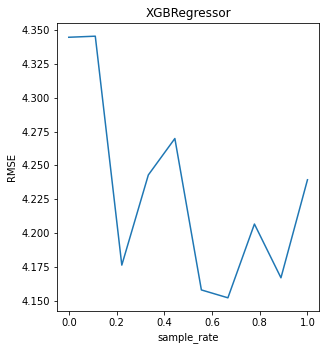

In [ ]:
plt.figure(figsize=(16, 18))

i = 1
for model_name, performance in results.items(): 
 plt.subplot(3, 3, i)
 i += 1
 
 plt.plot(sample_rates, performance)
 plt.title(model_name)
 plt.xlabel('sample_rate')
 plt.ylabel('RMSE')


plt.show()